# Principal Component Analysis

PCA is a technique used to reduce the dimensionality of the dataset. 

## Helicopter View into simple PCA Decomposition 

Let's make sure that we run the following command to install all needed packages:
`pip install -r requirements.txt`

Next, we're ready to import all relevant packages that were just installed:
* `numpy` for basic mathematical operations
* `pandas` for dataset manipulations 

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

We're now ready to use them to generate a simple dataset. We'll implement a data-generating function the results of which we'll be using as inputs to our PCA. 

The **aim of our exercise is to show, that results of principal components analysis align with theoretical, expected outcomes** for the dataset generated using the above function.

Our samples will be drawn from a Gaussian distribution in two dimensions, as follows:

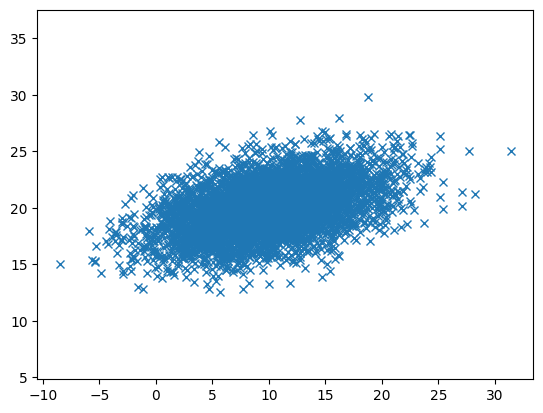

In [3]:
means = [10, 20]  # Means of marginal distributions
cov = [[25, 5], [5, 5]]  # diagonal covariance
x, y = np.random.multivariate_normal(means, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

PCA is based on eigenvalues and eigenvectors which can be computed using `numpy`:

In [4]:
values, vectors = np.linalg.eig(cov)
values[:5]

array([26.18033989,  3.81966011])

In [7]:
explained_variances = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values))
 
print(f"Total explained variance = {np.sum(explained_variances) * 100}%\nIndividual explained variances = {explained_variances}\n")

Total explained variance = 100.0%
Individual explained variances = [0.872677996249965, 0.12732200375003505]



We can see, that the variance is explained fully by the first two components. The first component explains over 87% of variance in the data.

## What's Going on in Depth?

We can visualize the eigenvectors and eigenvalues of the corresponding covariance matrix, which is defining the bivariate Gaussian distribution to see what they are describing. They are proven to be essential in the above PCA analysis. 

## References
* https://towardsdatascience.com/principal-component-analysis-pca-from-scratch-in-python-7f3e2a540c51